# SysArmy salaries dashboard

## Datasets

| Period  | Path             | URL                                                                                                         |
|---------|------------------|-------------------------------------------------------------------------------------------------------------|
| 2014.02 | data/2014.02.csv | http://sysarmy.com.ar/blog/wp-content/uploads/2015/01/sysarmy-resultados-encuesta-remuneracion-salarial.csv |
| 2015.01 | data/2015.01.csv | http://sysarmy.com.ar/blog/wp-content/uploads/2015/09/sysarmy-encuesta-salarial-julio-2015.csv              |
| 2016.01 | data/2016.01.csv | https://sysarmy.com.ar/blog/wp-content/uploads/2016/02/sysarmy-encuesta-salarial-enero-2016.csv             |
| 2016.02 | data/2016.02/    | https://sysarmy.com.ar/blog/wp-content/uploads/2016/08/encuesta-sueldos-sysarmy-openqube.zip                |
| 2017.01 | data/2017.01/    | https://docs.google.com/spreadsheets/d/1diZG7ruHJ4OgO2-tbnO-ZnhjxjOnYjMVSxl7I-4LT54/edit#gid=1424918437     |
| 2017.02 | -                | -                                                                                                           |


In [1]:
import pandas as pd
import numpy as np

def getPeriodColumnsDataFrame(period, csv_path, columns_src, columns_dst, transform = None):
    # give a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period']+columns_dst)
    df_dst.period = [period] * len(df_src)
    for i in range(len(columns_src)):
        df_dst[columns_dst[i]] = df_src.get(columns_src[i])
    if transform:
        df_dst = transform(df_src, df_dst);
    return df_dst

def incomeNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_src));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1.2048193
    df_dst.salary = net_factor * df_dst['salary']
    return df_dst

src_common_cols = ['Años de experiencia', 'Años en el puesto actual', 'Trabajo de', 'Tecnologías que utilizás']
dst_cols = ['salary', 'yoe', 'yip', 'role', 'stack']

df1 = getPeriodColumnsDataFrame('2014.02', '../data/2014.02.csv', ['Salario bruto mensual (AR$)'] + src_common_cols, dst_cols)
df2 = getPeriodColumnsDataFrame('2015.01', '../data/2015.01.csv', ['Salario bruto mensual (AR$)'] + src_common_cols, dst_cols)
df3 = getPeriodColumnsDataFrame('2016.01', '../data/2016.01.csv', ['Salario mensual (AR$)'] + src_common_cols, dst_cols)
df4 = getPeriodColumnsDataFrame('2016.02', '../data/2016.02/argentina.csv', ['Salario mensual (en tu moneda local)'] + src_common_cols, dst_cols, incomeNet2Brute)
df5 = getPeriodColumnsDataFrame('2017.01', '../data/2017.01/argentina.csv', ['Salario mensual (en tu moneda local)'] + src_common_cols, dst_cols, incomeNet2Brute)

def munge(df):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df.salary = df.salary.apply(lambda x: float(x))
    # discard out of range salaries (arbitrary range)
    df = df.loc[df.salary < 300000]
    df = df.loc[df.salary > 5000]
    # compute mean and std
    mu = np.mean(df.salary)
    sigma = np.std(df.salary)
    # apply rule of 68-95-99.7, by 95%
    df = df[ df.salary < mu + 2*sigma ]
    df = df[ df.salary > mu - 2*sigma ]
    return df

df = munge(pd.concat([df1, df2, df3, df4, df5]))
df[:10]

,period,salary,yoe,yip,role,stack
0,2014.02,21000.00,5 - 7,Menos de un año,SysAdmin,"Linux, """"""Cloud"""""""
1,2014.02,10000.00,10+,2 - 4,SysAdmin,Linux
2,2014.02,16000.00,3 - 5,1 - 2,DevOps,"Linux, """"""Cloud"""""""
3,2014.02,23771.13,5 - 7,1 - 2,SysAdmin,Linux
4,2014.02,16000.00,10+,2 - 4,DevOps,Linux
5,2014.02,17000.00,7 - 10,1 - 2,PM,NaN
6,2014.02,17250.00,5 - 7,6 - 10,Networking,NaN
7,2014.02,11000.00,7 - 10,2 - 4,Otro,NaN
8,2014.02,19176.00,5 - 7,1 - 2,Infosec,NaN
9,2014.02,9600.00,3 - 5,Menos de un año,DevOps,Linux


## Gaussian distribution 

* Probability density function 
 
$$
\large 
\DeclareMathOperator{\Norm}{\mathcal{N}} 
\DeclareMathOperator{\Gam}{Gam} 
\DeclareMathOperator{\e}{exp} 
p(x \mid \mu, \sigma^2) = \Norm(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \e\left\{ \frac{-(x - \mu)^2}{2\sigma^2} \right\}
$$
 
* Gaussian density paramters 
 
$$
\large 
\begin{align} 
\mu &= \frac{1}{N} \sum_i x_i \\ 
\sigma^2 &= \frac{1}{N} \sum_i x_i^2 
\end{align} 
$$

In [2]:
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.misc import logsumexp
%matplotlib inline

## Distribution of income by period (Argentina)

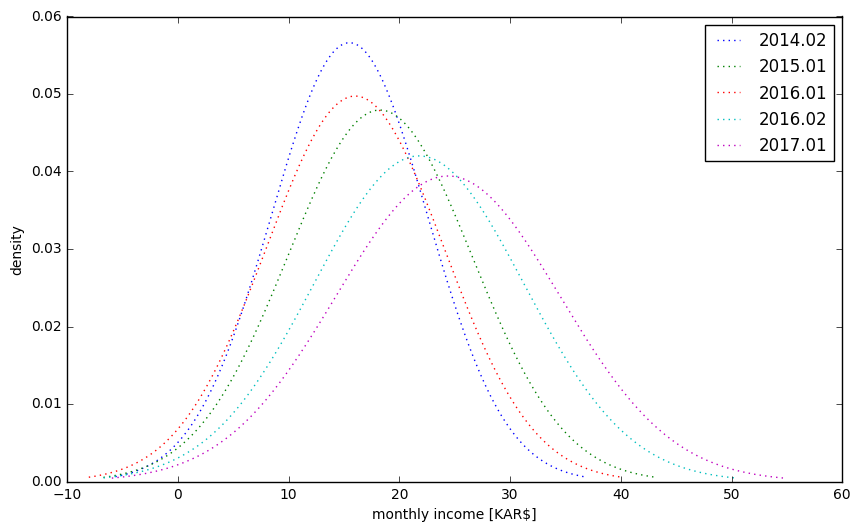

In [3]:
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 10})
plt.clf()
for period in df.period.unique():
    dft = df[df.period.str.contains(period)]
    salary = dft.salary.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu = np.mean(salary)
    sigma = np.std(salary)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    plt.plot(t, sps.norm.pdf(t, mu, sigma), label=period, ls=':')
plt.xlabel('monthly income [KAR$]'); plt.ylabel('density')
plt.legend()

### Dashboard

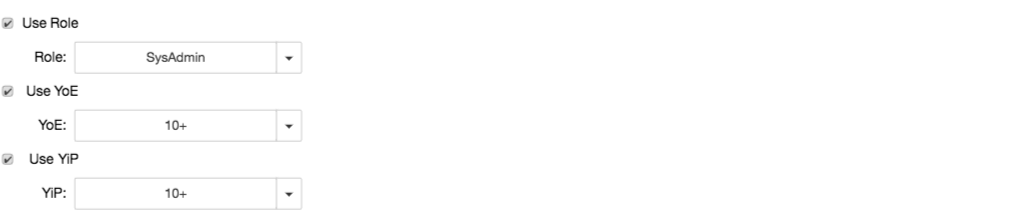

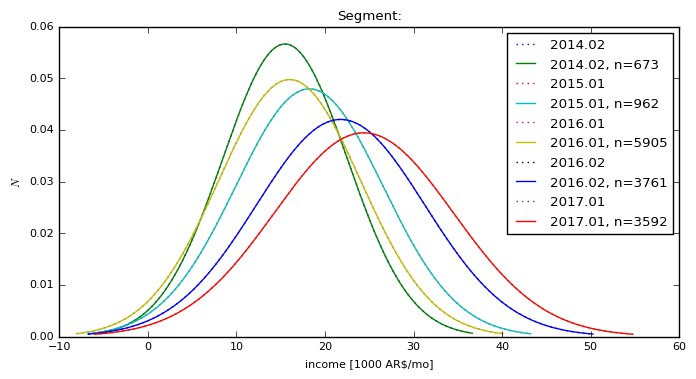

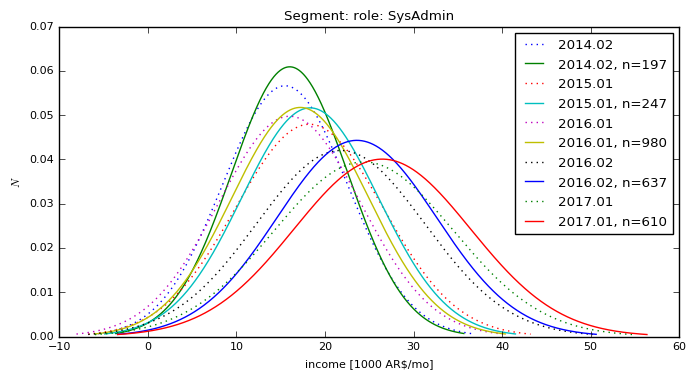

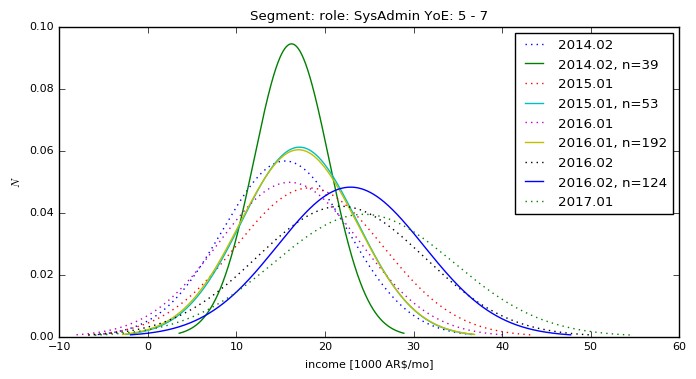

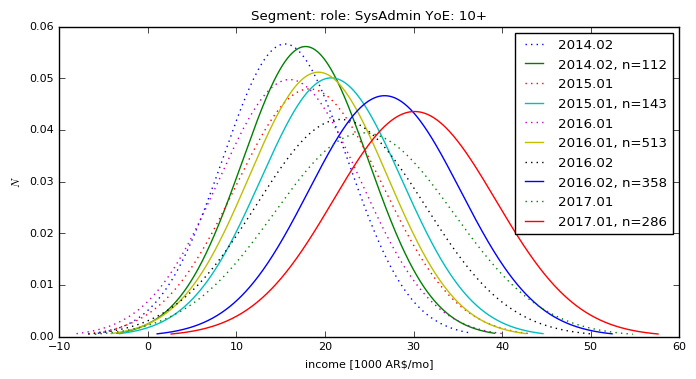

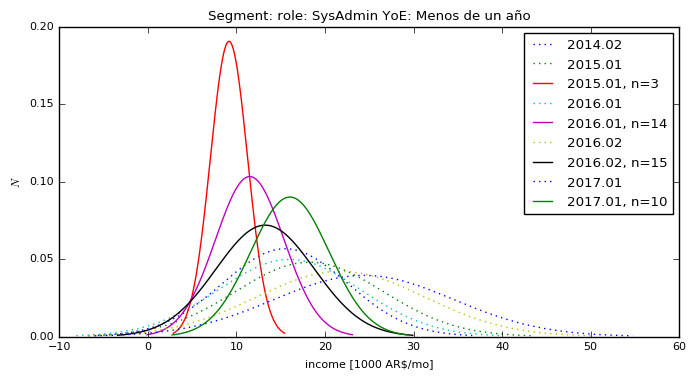

In [4]:
from IPython.display import clear_output
import ipywidgets as widgets

opts_role = list(df.role.unique())
opts_yoe = list(df.yoe.unique())
opts_yip = list(df.yip.unique())

use_role = widgets.Checkbox(value=False, description='Use Role', name='use_role',disabled=False)
control_role = widgets.Dropdown(options=opts_role, value=opts_role[0], name='role', description='Role:', disabled=not use_role.value)

use_yoe = widgets.Checkbox(value=False, description='Use YoE', name='use_yoe',disabled=False)
control_yoe = widgets.Dropdown(options=opts_yoe, value=opts_yoe[0], name='yoe', description='YoE:', disabled=not use_yoe.value)

use_yip = widgets.Checkbox(value=False, description='Use YiP', name='use_yip',disabled=False)
control_yip = widgets.Dropdown(options=opts_yip, value=opts_yip[0], name='yip', description='YiP:', disabled=not use_yip.value)

def on_filters_change(change):
    if change['owner'].name == 'use_role':
        control_role.disabled = not change['new']
    if change['owner'].name == 'use_yoe':
        control_yoe.disabled = not change['new']
    if change['owner'].name == 'use_yip':
        control_yip.disabled = not change['new']
    plot_filtered_monthly_income()

def plot_filtered_monthly_income(change = None):
    #clear_output()
    #plt.clf()
    # Plot gaussian distribution
    plt.rcParams.update({'figure.figsize': (8.0, 4.0), 'font.size': 8})
    for period in df.period.unique():
        dft = df[df.period.str.contains(period)]
        salary = dft.salary.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
        mu = np.mean(salary)
        sigma = np.std(salary)
        t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        plt.plot(t, sps.norm.pdf(t, mu, sigma), label=period, ls=':')
        title = 'Segment:'

        if not control_role.disabled:
            dft = dft[dft.role.str.contains(control_role.value)]
            title += ' role: %s' % control_role.value
        if not control_yoe.disabled:
            dft = dft[dft.yoe.str.contains(control_yoe.value)]
            title += ' YoE: %s' % control_yoe.value
        if not control_yip.disabled:
            dft = dft[dft.yip.str.contains(control_yip.value)]
            title += ' YiP: %s' % control_yip.value   
        plt.title(title)
        
        if len(dft) < 2:
            continue
        salary = dft.salary.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
        mu = np.mean(salary)
        sigma = np.std(salary)
        t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        plt.plot(t, sps.norm.pdf(t, mu, sigma), label=period + (', n=%d'%len(salary)), ls='-')
    plt.xlabel('income [1000 AR$/mo]'); plt.ylabel('$N$')
    plt.legend()

use_role.observe(on_filters_change, names='value')
control_role.observe(plot_filtered_monthly_income, names='value')
use_yoe.observe(on_filters_change, names='value')
control_yoe.observe(plot_filtered_monthly_income, names='value')
use_yip.observe(on_filters_change, names='value')
control_yip.observe(plot_filtered_monthly_income, names='value')

plot_filtered_monthly_income()
widgets.Box([use_role, control_role, use_yoe, control_yoe, use_yip, control_yip])